## Fundmental Analysis With FMP (this notebook)

### Will have the ability to pull & chart the following
* Income Sheet Statement
* Balance Sheet Statement
* Cash Flow Statement
* Key Metrics / Ratios
* Key Metrics / Ratios TTM
* Overview

## Fundmental Analysis With FMP (future demonstration)
* Using pyxll, create an Excel template to standardize fundemntal analysis
* Part of a larger analysis, which includes returns analysis, fundemental analysis, and technical analysis
* End Goal: presentable document with scoring element
* Note: fucntions need to be slightly modified to work with pyxll+Excel, but it will all stem from this code

### API credentials can be obtained from here: https://site.financialmodelingprep.com/

In [1]:
# Import Libraries

import os
import subprocess
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math
from scipy.stats import norm
import scipy.stats as stats
import requests

In [2]:
# All Parameters

ticker_main = 'AAPL'

### Key Functions

In [3]:
# type = 
# 'income-statement': This retrieves the income statement of the company.
# 'balance-sheet-statement': This retrieves the balance sheet of the company.
# 'cash-flow-statement': This retrieves the cash flow statement of the company.
# 'profile': This retrieves the company profile information.
# 'key-metrics': This retrieves key metrics of the company.
# 'key-metrics-ttm': This retrieves key metrics on a trailing twelve months basis.
# 'ratios-ttm': This retrieves ratios on a trailing twelve months basis.
# 'earning-calendar': This retrieves the earnings calendar information for the company.
    
# period = annual, quarter. Not tested for quarter
# formatted = yes means it will be formatted per the helper functions above

def get_fmp_data(ticker, type='income-statement', period='annual', formatted='no'):
    base_url = "https://financialmodelingprep.com/api/v3/"
    endpoint = f"{type}/{ticker}?period={period.lower()}"
    
    api_key = "DHSyvp2aSgfPp9ZqT9DTv7M6IVS6jmlU" # Replace this with your FMP API key if you have one
    # API Key comes from here: https://site.financialmodelingprep.com/
    # api_key = "API KEY HERE" # Replace this with your FMP API key if you have one
    
    # If an API key is provided, include it in the request URL
    if api_key:
        endpoint += f"&apikey={api_key}"
    
    response = requests.get(f"{base_url}{endpoint}")
    
    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        
        # Convert the data to a pandas DataFrame
        data_df = pd.DataFrame(data)
        
        # Check if 'date' column exists before setting it as the index
        if 'date' in data_df.columns:
            data_df.set_index('date', inplace=True)
        
        # Format Numeric Cols if 'formatted' parameter is set to 'yes'
        if formatted.lower() == 'yes':
            data_df = format_numeric_columns(data_df) 
            
        return data_df
    
    else:
        # If the request was not successful, print an error message and return None
        print(f"Error: Unable to fetch data for {ticker}. Status Code: {response.status_code}")
        return None

In [4]:
def plot_metric_by_year(income_statement_df, metric='revenue', scale='B', data_type='Integer', num_decimals=0, title=None, show_labels=True, show_cagr=False):
    years = pd.to_datetime(income_statement_df.index).year
    
    if metric in income_statement_df.columns:
        grouped_data = income_statement_df.groupby(years)[metric].sum()
        
        if scale == 'B':
            grouped_data /= 1_000_000_000
            unit = 'B'
        elif scale == 'M':
            grouped_data /= 1_000_000
            unit = 'M'
        elif scale == 'K':
            grouped_data /= 1_000
            unit = 'K'
        else:
            unit = ''
        
        plt.figure(figsize=(10, 6))
        plt.bar(grouped_data.index, grouped_data.values, edgecolor='black')
        if title:
            plt.title(title, fontsize=16)
        else:
            plt.title(f'{metric.capitalize()} Distribution by Year', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel(f'{metric.capitalize()}' + (f' ({unit})' if unit else ''), fontsize=14)
        plt.xticks(sorted(grouped_data.index))  

        # Explicitly set y-axis ticks and labels
        y_ticks = plt.gca().get_yticks()
        if data_type == 'Integer':
            y_labels = [f'{int(y):,}{unit}' if int(y) != 0 else f'{int(y)}{unit}' for y in y_ticks]
        elif data_type == 'Percent':
            y_labels = [f'{y:.2%}' for y in y_ticks]
        elif data_type == 'Decimal':
            y_labels = [f'{y:.{num_decimals}f}{unit}' for y in y_ticks]
        else:
            y_labels = [f'{y}{unit}' for y in y_ticks]
        
        plt.gca().set_yticks(y_ticks)
        plt.gca().set_yticklabels(y_labels)
        plt.ylim(0, max(grouped_data.values) * 1.2)  

        if show_cagr:
            window_3_years = 3
            window_5_years = 5
            cagr_3_years = income_statement_df[metric].pct_change(window=window_3_years) * 100
            cagr_5_years = income_statement_df[metric].pct_change(window=window_5_years) * 100
            plt.plot(income_statement_df.index[window_3_years:], cagr_3_years[window_3_years:], label='3-Year CAGR', marker='o')
            plt.plot(income_statement_df.index[window_5_years:], cagr_5_years[window_5_years:], label='5-Year CAGR', marker='o')
        
        if show_labels:
            for i, v in enumerate(grouped_data.values):
                plt.text(grouped_data.index[i], v, f'{v:.{num_decimals}f}{unit}', ha='center', va='bottom')
        
        # Remove the legend
        # plt.legend()
        plt.grid(False)  # Remove the gridlines
        plt.show()


### Example

In [5]:
df = get_fmp_data('AAPL')
df

,symbol,reportedCurrency,cik,fillingDate,acceptedDate,calendarYear,period,revenue,costOfRevenue,grossProfit,...,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink
date,,,,,,,,,,,,,,,,,,,,,
2023-09-30,AAPL,USD,0000320193,2023-11-03,2023-11-02 18:08:27,2023,FY,383285000000,214137000000,169148000000,...,0.296740,16741000000,96995000000,0.253062,6.16,6.13,15744231000,15812547000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...
2022-09-24,AAPL,USD,0000320193,2022-10-28,2022-10-27 18:01:14,2022,FY,394328000000,223546000000,170782000000,...,0.302040,19300000000,99803000000,0.253096,6.15,6.11,16215963000,16325819000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...
2021-09-25,AAPL,USD,0000320193,2021-10-29,2021-10-28 18:04:28,2021,FY,365817000000,212981000000,152836000000,...,0.298529,14527000000,94680000000,0.258818,5.67,5.61,16701272000,16864919000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...
2020-09-26,AAPL,USD,0000320193,2020-10-30,2020-10-29 18:06:25,2020,FY,274515000000,169559000000,104956000000,...,0.244398,9680000000,57411000000,0.209136,3.31,3.28,17352119000,17528214000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...
2019-09-28,AAPL,USD,0000320193,2019-10-31,2019-10-30 18:12:36,2019,FY,260174000000,161782000000,98392000000,...,0.252666,10481000000,55256000000,0.212381,2.99,2.97,18471336000,18595652000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...


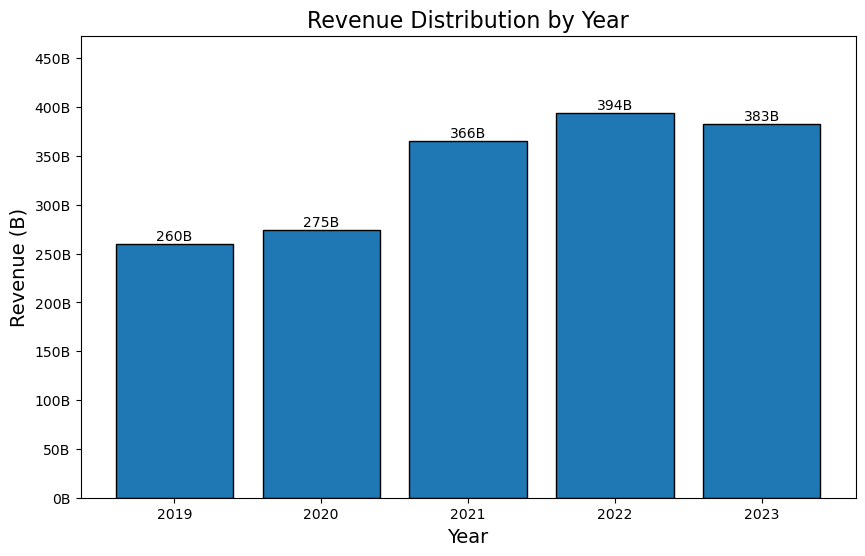

In [6]:
#with default
plot_metric_by_year(df)

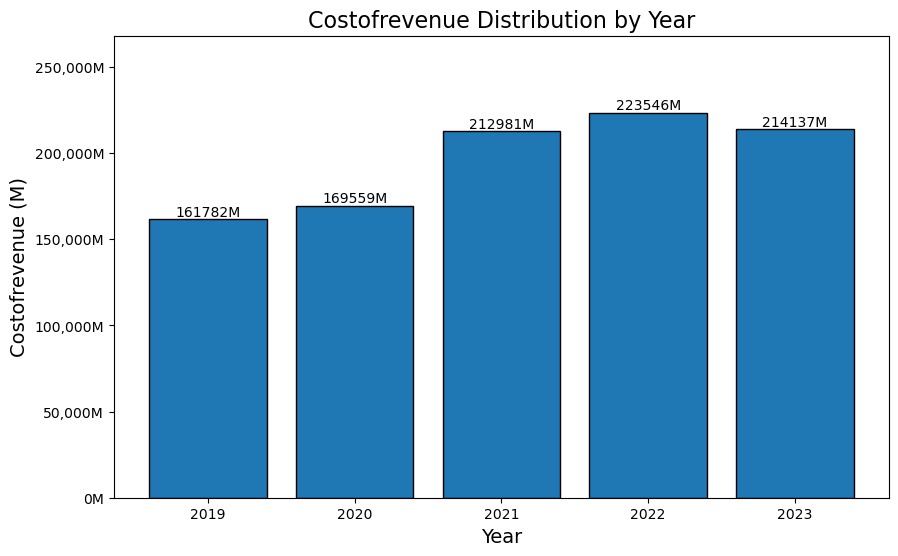

In [7]:
plot_metric_by_year(df,'costOfRevenue','M')

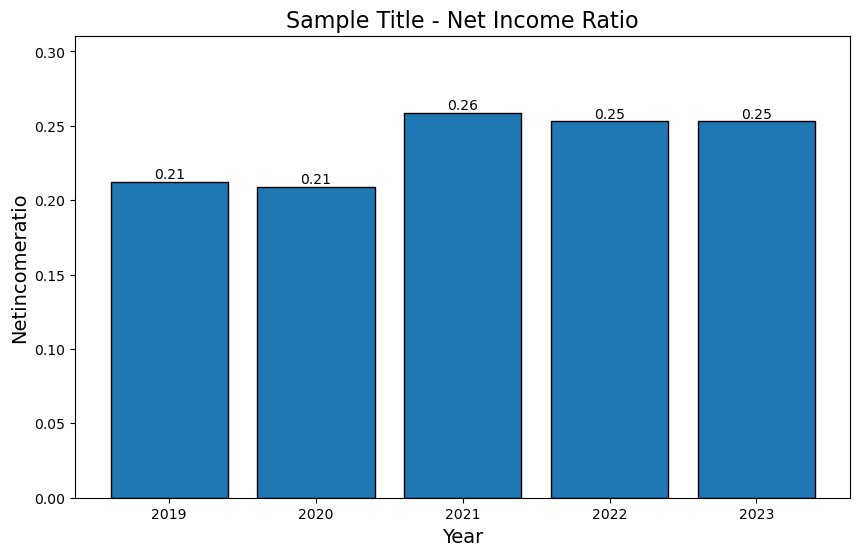

In [8]:
plot_metric_by_year(df,'netIncomeRatio','','Decimal',2,"Sample Title - Net Income Ratio")

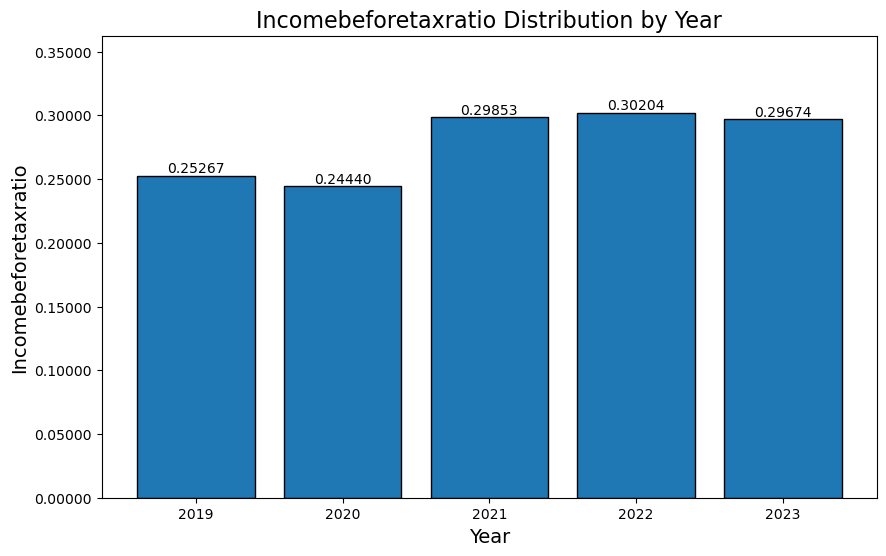

In [9]:
plot_metric_by_year(df,'incomeBeforeTaxRatio','','Decimal',5)